In [ ]:
from wikipedia import *
from operator import itemgetter
import requests
anchor2concept('Hello')

In [ ]:
id2title(48324759L)

In [ ]:
"""
Testing the Solr splitting
"""

import requests
import json
from wikipedia import *
from __future__ import division
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
import tagme

tagme.GCUBE_TOKEN = "f6c2ba6c-751b-4977-a94c-c140c30e9b92-843339462"

def get_solr_count(s):
    """ Gets the number of documents the string occurs 
        NOTE: Multi words should be quoted
    Arg:
        s: the string (can contain AND, OR, ..)
    Returns:
        The number of documents
    """

    q='+text:(\"%s\")'%(s,)
    qstr = 'http://localhost:8983/solr/enwiki20160305/select'
    params={'indent':'on', 'wt':'json', 'q':q, 'rows':0}
    r = requests.get(qstr, params=params)
    try:
        if 'response' not in r.json():
            return 0
        else:
            return r.json()['response']['numFound']
    except:
        return 0

def get_mention_count(s):
    """
    Description:
        Returns the amount of times that the given string appears as a mention in wikipedia.
    Args:
        s: the string (can contain AND, OR, ..)
    Return:
        The amount of times the given string appears as a mention in wikipedia
    """
    
    result = anchor2concept(s)
    rSum = 0
    for item in result:
        rSum += item[1]
        
    return rSum

def getTextMentions(line):
    """
    Description:
        A helper method to get the mentions in an evaluable format, includes the mentions'
        start and end.
    Args:
        line: The json data that has info that needs to be converted.
    Return:
        The mentions in the form [[start, end, text],...].
    """
    
    mentions = []
    curWord = 0 
    curStart = 0
    for mention in line['mentions']:
        while curWord < mention[0]:
            curStart += len(line['text'][curWord]) + 1
            curWord += 1
        mentions.append([curStart, curStart + len(line['text'][curWord]), line['text'][curWord]])
        
    return mentions

def destroyExclusiveOverlaps(textData):
    """
    Description:
        Removes all overlaps from text data, so that only the best mention in an
        overlap set is left.
    Args:
        textData: [[start, end, text, anchProb],...]
    Return:
        textData minus the unesescary parts of the overlapping
    """
    
    newTextData = [] # textData minus the unesescary parts of the overlapping
    overlappingSets = [] # stores arrays of the indexes of overlapping items from textData
    
    # creates the overlappingSets array
    i = 0
    while i < len(textData)-1:
        # even single elements considered overlapping set
        # this is root of overlapping set
        overlappingSets.append([i])
        overlapIndex = len(overlappingSets) - 1
        theBegin = textData[i][0]
        
        # look at next words untill not overlap
        for j in range(i+1, len(textData)):
            # if next word starts before endiest one ends
            if textData[j][0] == theBegin:
                overlappingSets[overlapIndex].append(j)
                i = j # make sure not to repeat overlap set
            else:
                # add final word
                if j == len(textData) - 1:
                    overlappingSets.append([j])
                break
        i += 1
                    
    # get only the best overlapping element of each set
    for oSet in overlappingSets:
        bestIndex = 0
        bestScore = -1
        for i in oSet:
            totalMentions = get_mention_count(textData[i][2])
            totalAppearances = get_solr_count(textData[i][2].replace(".", ""))
            if totalAppearances == 0:
                score = 0
            else:
                score = totalMentions/totalAppearances
            
            if score > bestScore:
                bestScore = score
                bestIndex = i
        
        # put right item in new textData
        newTextData.append(textData[bestIndex])
        
    return newTextData
                    
def getSolrMentions(text):
    """
    Description:
        A method to split the text and try to extract mentions using Solr.
    Args:
        text: The text to find mentions in.
    Return:
        The mentions as found from our method using Solr.
    """
    
    addr = 'http://localhost:8983/solr/enwikianchors20160305/tag'
    params={'overlaps':'ALL', 'tagsLimit':'5000', 'fl':'id','wt':'json','indent':'on'}
    r = requests.post(addr, params=params, data=text.encode('utf-8'))
    textData0 = r.json()['tags']
    
    textData = []
    # get rid of extra un-needed Solr data, and add in anchor probability
    for item in textData0:
        totalMentions = get_mention_count(text[item[1]:item[3]])
        totalAppearances = get_solr_count(text[item[1]:item[3]].replace(".", ""))
        if totalAppearances == 0:
            anchorProb = 0
        else:
            anchorProb = totalMentions/totalAppearances
        
        # put in the new clean textData
        textData.append([item[1], item[3], text[item[1]:item[3]], anchorProb])
    
    textData = destroyExclusiveOverlaps(textData)
    
    # gets the POS labels for the words
    postrs = []
    for item in textData:
        postrs.append(item[2])
    postrs = nltk.pos_tag(postrs)
    for i in range(0,len(textData)):
        textData[i].append(postrs[i]) # [4][1] is index of type of word
    
    mentions = []
    mentionPThrsh = 0.001
    
    for item in textData:
        if (item[3] >= mentionPThrsh
                and (item[4][1][0:2] == 'NN' or item[4][1] == 'JJ')):
            mentions.append([item[0], item[1], item[2]])
    
    return mentions

def precision(trueMentions, otherMentions):
    """
    Description:
        Calculates the precision of otherSet against the trueMentions.
    Args:
        trueMentions: The 'right' answers for what the mentions are.
        otherMentions: Our mentions obtained through some means.
    Return:
        The precision: (# of correct mentions)/(# of found mentions)
    """
    
    numFound = len(otherMentions)
    numCorrect = 0 # incremented in for loop
    
    trueIndex = 0
    otherIndex = 0
    
    while trueIndex < len(trueMentions) and otherIndex < len(otherMentions):
        # if mentions start and end on the same
        if (trueMentions[trueIndex][0] == otherMentions[otherIndex][0]
               and trueMentions[trueIndex][1] == otherMentions[otherIndex][1]):
            #print ('MATCH: [' + str(trueMentions[trueIndex][0]) + ',' + str(trueMentions[trueIndex][1]) + ']' + trueMentions[trueIndex][2] 
            #       + ' <===> [' + str(otherMentions[otherIndex][0]) + ',' + str(otherMentions[otherIndex][1]) + ']' + otherMentions[otherIndex][2])
            numCorrect += 1
            trueIndex += 1
            otherIndex += 1
        # if true mention starts before the other starts
        elif trueMentions[trueIndex][0] < otherMentions[otherIndex][0]:
            #print ('FAIL: [' + str(trueMentions[trueIndex][0]) + ',' + str(trueMentions[trueIndex][1]) + ']' + trueMentions[trueIndex][2] 
            #       + ' <XXX> [' + str(otherMentions[otherIndex][0]) + ',' + str(otherMentions[otherIndex][1]) + ']' + otherMentions[otherIndex][2])
            trueIndex += 1
        # if other mention starts before the true starts (same doesnt matter)
        elif trueMentions[trueIndex][0] >= otherMentions[otherIndex][0]:
            #print ('FAIL: [' + str(trueMentions[trueIndex][0]) + ',' + str(trueMentions[trueIndex][1]) + ']' + trueMentions[trueIndex][2] 
            #       + ' <XXX> [' + str(otherMentions[otherIndex][0]) + ',' + str(otherMentions[otherIndex][1]) + ']' + otherMentions[otherIndex][2])
            otherIndex += 1
        else:
            print 'AAAAAAAHHHHHHHHHHHHHHHHHHHHHHHHHHHHH!!!!!!!!!!!!!!!!!!!'

    print 'correct: ' + str(numCorrect) + '\nfound: ' + str(numFound)
    if numFound == 0:
        return 0
    else:
        return (numCorrect/numFound)

def recall(trueMentions, otherMentions):
    """
    Description:
        Calculates the recall of otherSet against the trueMentions.
    Args:
        trueMentions: The 'right' answers for what the mentions are.
        otherMentions: Our mentions obtained through some means.
    Return:
        The recall: (# of correct entities)/(# of actual entities)
    """
    
    numActual = len(trueMentions)
    numCorrect = 0 # incremented in for loop)
    
    trueIndex = 0
    otherIndex = 0
    
    while trueIndex < len(trueMentions) and otherIndex < len(otherMentions):
        # if mentions start and end on the same
        if (trueMentions[trueIndex][0] == otherMentions[otherIndex][0]
               and trueMentions[trueIndex][1] == otherMentions[otherIndex][1]):
            numCorrect += 1
            trueIndex += 1
            otherIndex += 1
        # if true mention starts before the other starts
        elif trueMentions[trueIndex][0] < otherMentions[otherIndex][0]:
            trueIndex += 1
        # if other mention starts before the true starts (same doesnt matter)
        elif trueMentions[trueIndex][0] >= otherMentions[otherIndex][0]:
            otherIndex += 1
        
    print 'correct: ' + str(numCorrect) + '\nactual: ' + str(numActual)
    if numActual == 0:
        return 0
    else:
        return (numCorrect/numActual)

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]

performances = {}

# for each dataset, run all methods
for dataset in datasets:
    performances[dataset['name']] = {}
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
    
    # reset counters
    totalPrec = 0
    totalRec = 0
    totalLines = 0

    # each method tests all lines
    for line in dataLines:

        print str(totalLines + 1)

        trueMentions = getTextMentions(line)
        solrMentions = getSolrMentions(" ".join(line['text']))
        
        print line['text']
        print trueMentions
        print str(solrMentions) + '\n'
        
        """solrMentions0 = tagme.mentions(" ".join(line['text']))
        solrMentions = []
        for item in solrMentions0.mentions:
            solrMentions.append([item.begin, item.end, item.mention])"""
        
        ## get statistical results from true mentions and solr mentions
        
        aNumber = len(solrMentions)/len(trueMentions)

        prec = precision(trueMentions, solrMentions)
        rec = recall(trueMentions, solrMentions)
        print str(prec) + ' ' + str(rec) + '\n'

        # track results
        totalPrec += prec
        totalRec += rec
        totalLines += 1

    # record results for this method on this dataset
    performances[dataset['name']] = {'Precision':totalPrec/totalLines, 
                                     'Recall':totalRec/totalLines}
            
print performances

In [ ]:
text = "Dalhousie University"

print get_mention_count(text)
print get_solr_count(text)

print get_mention_count(text)/get_solr_count(text)

```curl -X POST \
  'http://localhost:8983/solr/geonames/tag?overlaps=NO_SUB&tagsLimit=5000&fl=id,name,countrycode&wt=json&indent=on' \
  -H 'Content-Type:text/plain' -d 'Hello New York City'```
 

In [2]:
"""
Wikification for evaluation purposes
"""

from wikipedia import *
from operator import itemgetter
import requests
import json
from __future__ import division
import nltk
import scipy as sp
import scipy.sparse as sprs
import scipy.spatial
import scipy.sparse.linalg
from calcsim import *

MIN_MENTION_LENGTH = 3 # mentions must be at least this long
MIN_FREQUENCY = 20 # anchor with frequency below is ignored

def get_solr_count(s):
    """ Gets the number of documents the string occurs 
        NOTE: Multi words should be quoted
    Arg:
        s: the string (can contain AND, OR, ..)
    Returns:
        The number of documents
    """

    q='+text:(\"%s\")'%(s,)
    qstr = 'http://localhost:8983/solr/enwiki20160305/select'
    params={'indent':'on', 'wt':'json', 'q':q, 'rows':0}
    r = requests.get(qstr, params=params)
    try:
        if 'response' not in r.json():
            return 0
        else:
            return r.json()['response']['numFound']
    except:
        return 0

def get_mention_count(s):
    """
    Description:
        Returns the amount of times that the given string appears as a mention in wikipedia.
    Args:
        s: the string (can contain AND, OR, ..)
    Return:
        The amount of times the given string appears as a mention in wikipedia
    """
    
    result = anchor2concept(s)
    rSum = 0
    for item in result:
        rSum += item[1]
        
    return rSum

def destroyExclusiveOverlaps(textData):
    """
    Description:
        Removes all overlaps from text data, so that only the best mention in an
        overlap set is left.
    Args:
        textData: [[start, end, text, anchProb],...]
    Return:
        textData minus the unesescary elements that overlap.
    """
    
    newTextData = [] # textData minus the unesescary parts of the overlapping
    overlappingSets = [] # stores arrays of the indexes of overlapping items from textData
    
    # creates the overlappingSets array
    i = 0
    while i < len(textData)-1:
        # even single elements considered overlapping set
        # this is root of overlapping set
        overlappingSets.append([i])
        overlapIndex = len(overlappingSets) - 1
        theBegin = textData[i][0]
        
        # look at next words untill not overlap
        for j in range(i+1, len(textData)):
            # if next word starts before endiest one ends
            if textData[j][0] == theBegin:
                overlappingSets[overlapIndex].append(j)
                i = j # make sure not to repeat overlap set
            else:
                # add final word
                if j == len(textData) - 1:
                    overlappingSets.append([j])
                break
        i += 1
                    
    # get only the best overlapping element of each set
    for oSet in overlappingSets:
        bestIndex = 0
        bestScore = -1
        for i in oSet:
            totalMentions = get_mention_count(textData[i][2])
            totalAppearances = get_solr_count(textData[i][2].replace(".", ""))
            if totalAppearances == 0:
                score = 0
            else:
                score = totalMentions/totalAppearances
            
            if score > bestScore:
                bestScore = score
                bestIndex = i
        
        # put right item in new textData
        newTextData.append(textData[bestIndex])
        
    return newTextData

def mentionStartsAndEnds(textData, forTruth = False):
    """
    Description:
        Takes in a list of mentions and turns each of its mentions into the form: [wIndex, start, end]. 
        Or if forTruth is true: [[start,end,entityId]]
    Args:
        textData: {'text': [w1,w2,w3,...] , 'mentions': [[wordIndex,entityTitle],...]}, to be transformed 
            as described above.
        forTruth: Changes form to use.
    Return:
        The mentions in the form [[wIndex, start, end],...]]. Or if forTruth is true: [[start,end,entityId]]
    """
    
    curWord = 0 
    curStart = 0
    for mention in textData['mentions']:
        while curWord < mention[0]:
            curStart += len(textData['text'][curWord]) + 1
            curWord += 1
            
        ent = mention[1] # store entity title in case of forTruth
        mention.pop() # get rid of entity text
        
        if forTruth:
            mention.pop() # get rid of wIndex too
            
        mention.append(curStart) # start of the mention
        mention.append(curStart + len(textData['text'][curWord])) # end of the mention
        
        if forTruth:
            mention.append(title2id(ent)) # put on entityId
    
    return textData['mentions']
     
def mentionExtract(text):
    """
    Description:
        Takes in a text and splits it into the different words/mentions.
    Args:
        phrase: The text to be split.
    Return:
        The text split it into the different words / mentions: 
        {'text':[w1,w2,...], 'mentions': [[wIndex,begin,end],...]}
    """
    
    addr = 'http://localhost:8983/solr/enwikianchors20160305/tag'
    params={'overlaps':'ALL', 'tagsLimit':'5000', 'fl':'id','wt':'json','indent':'on'}
    r = requests.post(addr, params=params, data=text.encode('utf-8'))
    textData0 = r.json()['tags']
    
    splitText = [] # the text now in split form
    mentions = [] # mentions before remove inadequate ones
    
    textData = [] # [[begin,end,word,anchorProb],...]
    
    i = 0 # for wordIndex
    # get rid of extra un-needed Solr data, and add in anchor probability
    for item in textData0:
        totalMentions = get_mention_count(text[item[1]:item[3]])
        totalAppearances = get_solr_count(text[item[1]:item[3]].replace(".", ""))
        if totalAppearances == 0:
            anchorProb = 0
        else:
            anchorProb = totalMentions/totalAppearances
        # put in the new clean textData
        textData.append([item[1], item[3], text[item[1]:item[3]], anchorProb, i])
        i += 1
        
        # also fill split text
        splitText.append(text[item[1]:item[3]])
    
    # get rid of overlaps
    #textData = destroyExclusiveOverlaps(textData)
        
    # gets the POS labels for the words
    postrs = []
    for item in textData:
        postrs.append(item[2])
    postrs = nltk.pos_tag(postrs)
    for i in range(0,len(textData)):
        textData[i].append(postrs[i]) # [5][1] is index of type of word
    
    mentionPThrsh = 0.001 # for getting rid of unlikelies
    
    # put in only good mentions
    for item in textData:
        if (item[3] >= mentionPThrsh # if popular enough, and either some type of noun or JJ
                and (item[5][1][0:2] == 'NN' or item[5][1] == 'JJ')):
            mentions.append([item[4], item[0], item[1]]) # wIndex, start, end
    
    # get in same format as dataset provided data
    newTextData = {'text':splitText, 'mentions':mentions}
    
    return newTextData

def generateCandidates(textData, maxC, oText):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase.
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    
    candidates = []
    #print textData['text']
    for mention in textData['mentions']:
        
        # get all concepts for the anchor
        concepts = anchor2concept(textData['text'][mention[0]])
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = getMentionSentence(oText, mention)
        context = escapeStringSolr(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0', 'rows': str(maxC),
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^1.35',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json()
                   or 'docs' not in r.json()['response']
                   or len(r.json()['response']['docs']) == 0):
                for doc in r.json()['response']['docs'][:maxC]:
                    freq = 0
                    for concept in concepts:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            freq = concept[1]
                    solrRes.append([long(doc['id']), freq, doc['score']])
        except:
            solrRes = []
                
        # sort by frequency
        solrRes = sorted(solrRes, key = itemgetter(1), reverse = True)
        
        #print '\nMention: ' + textData['text'][mention[0]]
        #for res in solrRes:
        #    print '[' + id2title(res[0]) + '] -> freq: ' + str(res[1]) + ', rel: ' + str(res[2])
        
        candidates.append(solrRes) # take up to maxC of the results
    
    return candidates

def precision(truthSet, mySet):
    """
    Description:
        Calculates the precision of mySet against the truthSet.
    Args:
        truthSet: The 'right' answers for what the entities are. [[start,end,id],...]
        mySet: My code's output for what it thinks the right entities are. [[start,end,id],...]
    Return:
        The precision: (# of correct entities)/(# of found entities)
    """
    
    numFound = len(mySet)
    numCorrect = 0 # incremented in for loop
    
    truthIndex = 0
    myIndex = 0
    
    while truthIndex < len(truthSet) and myIndex < len(mySet):
        if mySet[myIndex][0] < truthSet[truthIndex][0]:
            if mySet[myIndex][1] > truthSet[truthIndex][0]:
                # overlap with mine behind
                if truthSet[truthIndex][2] == mySet[myIndex][2]:
                    numCorrect += 1
                    truthIndex += 1
                    myIndex += 1
                elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                    # truth ends first
                    truthIndex += 1
                else:
                    # mine ends first
                    myIndex += 1
            else:
                # mine not even reach truth
                myIndex += 1
                
        elif mySet[myIndex][0] == truthSet[truthIndex][0]:
            # same mention (same start atleast)
            if truthSet[truthIndex][2] == mySet[myIndex][2]:
                numCorrect += 1
                truthIndex += 1
                myIndex += 1
            elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                # truth ends first
                truthIndex += 1
            else:
                # mine ends first
                myIndex += 1
                  
        elif mySet[myIndex][0] > truthSet[truthIndex][0]:
            if mySet[myIndex][0] < truthSet[truthIndex][1]:
                # overlap with truth behind
                if truthSet[truthIndex][2] == mySet[myIndex][2]:
                    numCorrect += 1
                    truthIndex += 1
                    myIndex += 1
                elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                    # truth ends first
                    truthIndex += 1
                else:
                    # mine ends first
                    myIndex += 1
            else:
                # mine beyond mention, increment truth
                truthIndex += 1

    print 'correct: ' + str(numCorrect) + '\nfound: ' + str(numFound)
    if numFound == 0:
        return 0
    else:
        return (numCorrect/numFound)

def recall(truthSet, mySet):
    """
    Description:
        Calculates the recall of mySet against the truthSet.
    Args:
        truthSet: The 'right' answers for what the entities are. [[start,end,id],...]
        mySet: My code's output for what it thinks the right entities are. [[start,end,id],...]
    Return:
        The recall: (# of correct entities)/(# of actual entities)
    """
    
    numActual = len(truthSet)
    numCorrect = 0 # incremented in for loop)
    
    truthIndex = 0
    myIndex = 0
    
    while truthIndex < len(truthSet) and myIndex < len(mySet):
        if mySet[myIndex][0] < truthSet[truthIndex][0]:
            if mySet[myIndex][1] > truthSet[truthIndex][0]:
                # overlap with mine behind
                if truthSet[truthIndex][2] == mySet[myIndex][2]:
                    numCorrect += 1
                    truthIndex += 1
                    myIndex += 1
                elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                    # truth ends first
                    truthIndex += 1
                else:
                    # mine ends first
                    myIndex += 1
            else:
                # mine not even reach truth
                myIndex += 1
                
        elif mySet[myIndex][0] == truthSet[truthIndex][0]:
            # same mention (same start atleast)
            if truthSet[truthIndex][2] == mySet[myIndex][2]:
                numCorrect += 1
                truthIndex += 1
                myIndex += 1
            elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                # truth ends first
                truthIndex += 1
            else:
                # mine ends first
                myIndex += 1
                  
        elif mySet[myIndex][0] > truthSet[truthIndex][0]:
            if mySet[myIndex][0] < truthSet[truthIndex][1]:
                # overlap with truth behind
                if truthSet[truthIndex][2] == mySet[myIndex][2]:
                    numCorrect += 1
                    truthIndex += 1
                    myIndex += 1
                elif truthSet[truthIndex][1] < mySet[myIndex][1]:
                    # truth ends first
                    truthIndex += 1
                else:
                    # mine ends first
                    myIndex += 1
            else:
                # mine beyond mention, increment truth
                truthIndex += 1
                
    if numActual == 0:
        return 0
    else:
        return (numCorrect/numActual)
    
def getSurroundingWords(text, mIndex, window, asList = False):
    """
    Description:
        Returns the words surround the given mention. Expanding out window elements
        on both sides.
    Args:
        text: A list of words.
        mIndex: The index of the word that is the center of where to get surrounding words.
        window: The amount of words to the left and right to get.
        asList: Whether to return the words as a list, otherwise just a string.
    Return:
        The words that surround the given mention. Expanding out window elements
        on both sides.
    """
    
    imin = mIndex - window
    imax = mIndex + window + 1
    
    # fix extreme bounds
    if imin < 0:
        imin = 0
    if imax > len(text):
        imax = len(text)
        
    if asList == True:
        words = (text[imin:mIndex] + text[mIndex+1:imax])
    else:
        words = " ".join(text[imin:mIndex] + text[mIndex+1:imax])
    
    # return surrounding part of word minus the mIndex word
    return words

def getMentionSentence(text, mention, asList = False):
    """
    Description:
        Returns the sentence of the mention, minus the mention.
    Args:
        text: The text to get the sentence from.
        index: The mention.
        asList: Whether to return the words as a list, otherwise just a string.
    Return:
        The sentence of the mention, minus the mention.
    """
    
    # the start and end indexes of the sentence
    sStart = 0
    sEnd = 0
    
    # get sentences using nltk
    sents = nltk.sent_tokenize(text)
    
    # find sentence that mention is in
    curLen = 0
    for s in sents:
        curLen += len(s)
        # if greater than begin of mention
        if curLen > mention[1]:
            # remove mention from string to not get bias from self referencing article
            if asList == True:
                sentence = (s.replace(text[mention[1]:mention[2]],"")).split(" ")
            else:
                sentence = s.replace(text[mention[1]:mention[2]],"")
            
            return sentence
        
    # in case it missed
    if asList == True:
        return []
    else:
        return ""

def escapeStringSolr(text):
    """
    Description:
        Escapes a given string for use in Solr.
    Args:
        text: The string to escape.
    Return:
        The escaped text.
    """
    
    text = text.replace("\\", "\\\\\\")
    text = text.replace('+', r'\+')
    text = text.replace("-", "\-")
    text = text.replace("&&", "\&&")
    text = text.replace("||", "\||")
    text = text.replace("!", "\!")
    text = text.replace("(", "\(")
    text = text.replace(")", "\)")
    text = text.replace("{", "\{")
    text = text.replace("}", "\}")
    text = text.replace("[", "\[")
    text = text.replace("]", "\]")
    text = text.replace("^", "\^")
    text = text.replace("\"", "\\\"")
    text = text.replace("~", "\~")
    text = text.replace("*", "\*")
    text = text.replace("?", "\?")
    text = text.replace(":", "\:")
    
    return text

def bestContextMatch(mentionStr, context, candidates):
    """
    Description:
        Uses Solr to find the candidate that gives the highest relevance when given the context.
    Args:
        mentionStr: The mention as it appears in the text
        context: The words that surround the target word.
        candidates: A list of candidates that each have the entity id and its frequency/popularity.
    Return:
        The index of the candidate with the best relevance score from the context.
    """
    
    # put text in right format
    context = escapeStringSolr(context)
    mentionStr = escapeStringSolr(mentionStr)
    
    strIds = ['id:' +  str(strId[0]) for strId in candidates]
    
    # select all the docs from Solr with the best scores, highest first.
    addr = 'http://localhost:8983/solr/enwiki20160305/select'
    params={'fl':'id score', 'fq':" ".join(strIds), 'indent':'on',
            'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^0',
            'wt':'json'}
    r = requests.get(addr, params = params)
    
    if 'response' not in r.json():
        return 0 # default to most popular
    
    if 'docs' not in r.json()['response']:
        return 0
    
    results = r.json()['response']['docs']
    if len(results) == 0:
        return 0 # default to most popular
    
    bestId = long(r.json()['response']['docs'][0]['id'])
    
    #for doc in r.json()['response']['docs']:
        #print '[' + id2title(doc['id']) + '] -> ' + str(doc['score'])
    
    # find which index has bestId
    bestIndex = 0
    for cand in candidates:
        if cand[0] == bestId:
            return bestIndex
        else:
            bestIndex += 1
            
    return bestIndex # in case it was missed

def bestWord2VecMatch(context, candidates):
    """
    Description:
        Uses word2vec to find the candidate with the best similarity to the context.
    Args:
        context: The words that surround the target word as a list.
        candidates: A list of candidates that each have the entity id and its frequency/popularity.
    Return:
        The index of the candidate with the best similarity score with the context.
    """
    
    ctxVec = pd.Series(sp.zeros(500)) # default zero vector
    # add all context words together
    for word in context:
        ctxVec += getword2vector(word)
        
    # compare context vector to each of the candidates
    bestIndex = 0
    bestScore = 0
    i = 0
    for cand in candidates:
        eVec = getentity2vector(cand[0])
        score = 1-sp.spatial.distance.cosine(ctxVec, eVec)
        #print '[' + id2title(cand[0]) + ']' + ' -> ' + str(score)
        # update score and index
        if score > bestScore: 
            bestIndex = i
            bestScore = score
            
        i += 1 # next index
            
    return bestIndex
    
def wikifyPopular(textData, candidates):
    """
    Description:
        Chooses the most popular candidate for each mention.
    Args:
        textData: A text in split form along with its suspected mentions.
        candidates: A list of list of candidates that each have the entity id and its frequency/popularity.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    topCandidates = []
    i = 0 # track which mention's candidates we are looking at
    # for each mention choose the top candidate
    for mention in textData['mentions']:
        if len(candidates[i]) > 0:
            topCandidates.append([mention[1], mention[2], candidates[i][0][0]])
        i += 1 # move to list of candidates for next mention
            
    return topCandidates

def wikifyContext(textData, candidates, oText, useSentence = False, window = 7):
    """
    Description:
        Chooses the candidate that has the highest relevance with the surrounding window words.
    Args:
        textData: A textData in split form along with its suspected mentions.
        candidates: A list of candidates that each have the entity id and its frequency/popularity.
        oText: The original text to be used for getting sentence.
        useSentence: Whether to set use whole sentence as context, or just windowsize.
        window: How many words on both sides of a mention to search for context.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    topCandidates = []
    i = 0 # track which mention's candidates we are looking at
    # for each mention choose the top candidate
    for mention in textData['mentions']:
        if len(candidates[i]) > 0:
            if not useSentence:
                context = getSurroundingWords(textData['text'], mention[0], window)
            else:
                context = getMentionSentence(oText, mention)
            #print '\nMention: ' + textData['text'][mention[0]]
            #print 'Context: ' + context
            bestIndex = bestContextMatch(textData['text'][mention[0]], context, candidates[i])
            topCandidates.append([mention[1], mention[2], candidates[i][bestIndex][0]])
        i += 1 # move to list of candidates for next mention
        
    return topCandidates

def wikifyWord2Vec(textData, candidates, oText, useSentence = False, window = 5):
    """
    Description:
        Chooses the candidates that have the highest similarity to the context.
    Args:
        textData: A textData in split form along with its suspected mentions.
        candidates: A list of candidates that each have the entity id and its frequency/popularity.
        oText: The original text to be used for getting sentence.
        useSentence: Whether to set use whole sentence as context, or just windowsize.
        window: How many words on both sides of a mention to search for context.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    topCandidates = []
    i = 0 # track which mention's candidates we are looking at
    # for each mention choose the top candidate
    for mention in textData['mentions']:
        if len(candidates[i]) > 0:
            if not useSentence:
                context = getSurroundingWords(textData['text'], mention[0], window, asList = True)
            else:
                context = getMentionSentence(oText, mention, asList = True)
            #print '\nMention: ' + textData['text'][mention[0]]
            #print 'Context: ' + " ".join(context)
            bestIndex = bestWord2VecMatch(context, candidates[i])
            topCandidates.append([mention[1], mention[2], candidates[i][bestIndex][0]])
        i += 1 # move to list of candidates for next mention
        
    return topCandidates

def wikifyPopRel(textData, candidates, relThresh = 22):
    """
    Description:
        Essentially a combonation between choosing the most popular and most relevant. Over a certain
        threshold of relevance the most relevant one is chosen, otherwise most frequent/popular is chosen.
    Args:
        textData: A textData in split form along with its suspected mentions.
        candidates: A list of candidates that each have the entity id and its frequency/popularity and relevance.
        relThresh: When top relevancy is above this, go with most relevant.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    topCandidates = []
    i = 0 # track which mention's candidates we are looking at
    # for each mention choose the top candidate
    for mention in textData['mentions']:
        if len(candidates[i]) > 0:
            mostRel = sorted(candidates[i], key = itemgetter(2), reverse = True)[0]
            # get most relevant if relevancy high enough
            if mostRel[2] >= relThresh:
                topCandidates.append([mention[1], mention[2], mostRel[0]])
            else: # else go with most popular
                topCandidates.append([mention[1], mention[2], candidates[i][0][0]])
        i += 1 # move to list of candidates for next mention
            
    return topCandidates

def wikifyEval(text, mentionsGiven, maxC = 20, method='popular', strict = False):
    """
    Description:
        Takes the text (maybe text data), and wikifies it for evaluation purposes using the desired method.
    Args:
        text: The string to wikify. Either as just the original string to be modified, or in the 
            form of: [[w1,w2,...], [[wid,entityId],...] if the mentions are given.
        mentionsGiven: Whether the mentions are given to us and the text is already split.
        maxC: The max amount of candidates to extract.
        method: The method used to wikify.
        strict: Whether to use such rules as minimum metion length, or minimum frequency of concept.
    Return:
        All of the proposed entities for the mentions, of the form: [[start,end,entityId],...].
    """
    
    if not(mentionsGiven): # if words are not in pre-split form
        textData = mentionExtract(text) # extract mentions from text
        oText = text # the original text
    else: # if they are
        textData = text
        textData['mentions'] = mentionStartsAndEnds(textData) # put mentions in right form
        oText = " ".join(text['text'])
    
    # get rid of small mentions
    if strict:
        textData['mentions'] = [item for item in textData['mentions']
                    if  len(textData['text'][item[0]]) >= MIN_MENTION_LENGTH]
    
    candidates = generateCandidates(textData, maxC, oText)
    
    if method == 'popular':
        wikified = wikifyPopular(textData, candidates)
    elif method == 'context':
        wikified = wikifyContext(textData, candidates, oText, useSentence = True, window = 7)
    elif method == 'word2vec':
        wikified = wikifyWord2Vec(textData, candidates, oText, useSentence = True, window = 5)
    elif method == 'popRel':
        wikified = wikifyPopRel(textData, candidates, relThresh = 22)
    
    # get rid of very unpopular mentions
    if strict:
        wikified = [item for item in wikified
                    if item[3] >= MIN_FREQUENCY]
        
    return wikified

In [ ]:
"""
This is for testing performance of different wikification methods.
"""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme

tagme.GCUBE_TOKEN = "f6c2ba6c-751b-4977-a94c-c140c30e9b92-843339462"
    

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

methods = ['popRel']

#if 'word2vec' in methods: # run in different cell
    #word2vec = gensim_loadmodel('/users/cs/amaral/cgmdir/word2vecfiles/word2vec.enwiki-20160305-replace_surface.1.0.500.5.5.15.5.5')

performances = {}

# for each dataset, run all methods
for dataset in datasets:
    performances[dataset['name']] = {}
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines that contain proper ascii
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    
    # run each method on the data set
    for mthd in methods:
        print mthd
        print str(datetime.now()) + '\n'
        
        # reset counters
        totalPrecS = 0
        totalPrecM = 0
        totalRecS = 0
        totalRecM = 0
        totalLines = 0
        
        # each method tests all lines
        for line in dataLines:
            
            print str(totalLines + 1)
            
            # original split string with mentions given
            #resultS = wikifyEval(copy.deepcopy(line), True, maxC = 15, method = mthd)
            resultS = []
            # unsplit string to be manually split and mentions found
            resultM = wikifyEval(" ".join(line['text']), False, maxC = 15, method = mthd)
            # get absolute text indexes and entity id of each given mention
            trueEntities = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True) # the ground truth
                
            ## get statistical results from true entities and results S and M
            precS = precision(trueEntities, resultS) # precision of pre-split
            precM = precision(trueEntities, resultM) # precision of manual split
            recS = recall(trueEntities, resultS) # recall of pre-split
            recM = recall(trueEntities, resultM) # recall of manual split
            
            #clear_output() # delete this after
            print str(precS) + ' ' + str(precM) + ' ' + str(recS) + ' ' + str(recM) + '\n'
            #print str(precS) + ' ' + str(recS)
            
            # track results
            totalPrecS += precS
            totalPrecM += precM
            totalRecS += recS
            totalRecM += recM
            totalLines += 1
        
        # record results for this method on this dataset
        # [avg precision split, avg precision manual, avg recall split, avg recall manual]
        performances[dataset['name']][mthd] = {'S Prec':totalPrecS/totalLines, 
                                               'M Prec':totalPrecM/totalLines,
                                              'S Rec':totalRecS/totalLines, 
                                               'M Rec':totalRecM/totalLines}
            
print performances

In [ ]:
word2vec = gensim_loadmodel('/users/cs/amaral/cgmdir/word2vecfiles/word2vec.enwiki-20160305-replace_surface.1.0.500.5.5.15.5.5')

In [ ]:
"""
This is for testing performance of TagMe wikification method.
"""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme

tagme.GCUBE_TOKEN = "f6c2ba6c-751b-4977-a94c-c140c30e9b92-843339462"
    

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]

performances = {}

# for each dataset, run all methods
for dataset in datasets:
    performances[dataset['name']] = {}
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines that contain proper ascii
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'

    print str(datetime.now()) + '\n'

    # reset counters
    totalPrecM = 0
    totalRecM = 0
    totalLines = 0

    # each method tests all lines
    for line in dataLines:

        print str(totalLines + 1)
        
        antns = tagme.annotate(" ".join(line['text']))
        resultM = []
        for an in antns.get_annotations(0.005):
            resultM.append([an.begin,an.end,title2id(an.entity_title)])
        trueEntities = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True) # the ground truth

        ## get statistical results from true entities and results
        precM = precision(trueEntities, resultM)
        recM = recall(trueEntities, resultM)

        #clear_output() # delete this after
        print str(precM) + ' ' + str(recM) + '\n'
        #print str(precS) + ' ' + str(recS)

        # track results
        totalPrecM += precM
        totalRecM += recM
        totalLines += 1

    # record results for this method on this dataset
    # [avg precision split, avg precision manual, avg recall split, avg recall manual]
    performances[dataset['name']] = {'Precision':totalPrecM/totalLines,
                                          'Recall':totalRecM/totalLines}
            
print performances

In [16]:
"""Try to compare the difference between mentions where the entity is the most popular and when it is not"""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt

def generateCandidates(textData, maxC, oText):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase (most frequent).
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    candidates = []
    
    for mention in textData['mentions']:
        
        concepts = sorted(anchor2concept(textData['text'][mention[0]]), key = itemgetter(1), 
                          reverse = True)[:maxC]
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = getMentionSentence(oText, mention)
        context = escapeStringSolr(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0',
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^1.35',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json() 
                    or 'docs' not in r.json()['response'] 
                    or len(r.json()['response']['docs']) == 0):
                for concept in concepts:
                    score = 0
                    for doc in r.json()['response']['docs']:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            score = doc['score']
                            break
                    solrRes.append([concept[0], concept[1], score])
        except:
            solrRes = []
                
        # sort by frequency
        solrRes = sorted(solrRes, key = itemgetter(1), reverse = True)
        candidates.append(solrRes) # take up to maxC of the results
        
    return candidates

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 50
corCandPosDict = {} # dictionary containing the amount of correct entities found at each index
correctPositions = []
relevancies = []
for i in range(-1, maxC):
    corCandPosDict[str(i)] = 0

totalMentions = 0

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
        oText = " ".join(line['text'])
            
        candss = generateCandidates(line, maxC, oText)
        
        i = 0
        for cands in candss:
            corCand = False
            for j in range(0, len(cands)):
                if cands[j][0] == oMentions[i][2]:
                    correctPositions.append(j)
                    relevancies.append(cands[j][2])
                    corCand = True
                    break
            if corCand == False:
                correctPositions.append(-1)
                relevancies.append(-1)
            i += 1
            
            
        totalLines += 1
        
clear_output()

popRel = []
for i in range(0, len(correctPositions):
    popRel.append([correctPositions[i], relevancies[i]])

TypeError: range() integer end argument expected, got list.

In [20]:
posRels = []
for i in range(0, len(correctPositions)):
    posRels.append([correctPositions[i], relevancies[i]])

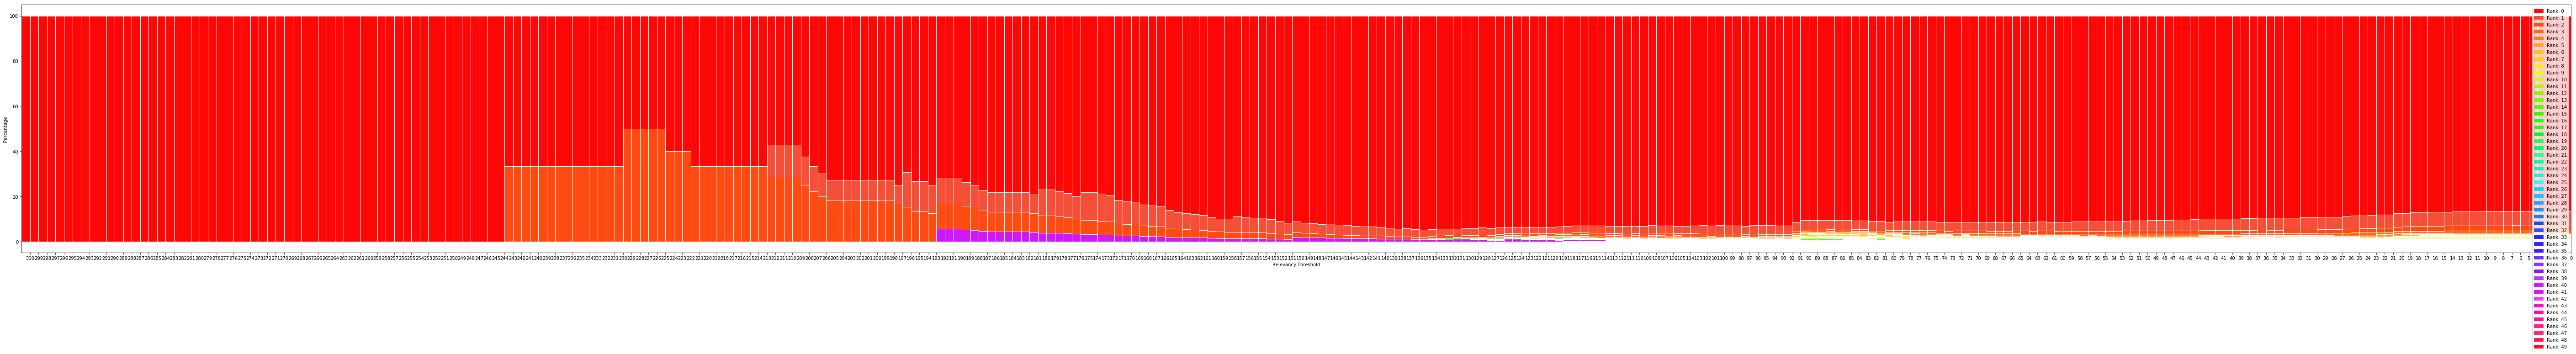

In [27]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import copy
import numpy as np


##### https://stackoverflow.com/questions/470690/how-to-automatically-generate-n-distinct-colors
##### Uri Cohen
import colorsys
def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors
#####
#####

maxC = 50
df = pickle.load(open('/users/cs/amaral/wikisim/storage/correct-pos-frequencies.pkl', 'rb'))

# https://chrisalbon.com/python/matplotlib_percentage_stacked_bar_plot.html
f, ax = plt.subplots(1, figsize =(100,10))
bar_width = 1
bar_l = [i for i in range(len(df['freq_lvl']))]
tick_pos = [i+(bar_width/2) for i in bar_l]

# get the total at each level
totals = []
totalIndex = -1
for i in range(0,len(df['freq_lvl'])):
    totals.append(0)
    totalIndex += 1
    for j in range(0,maxC):
        totals[totalIndex] += df['rank: ' + str(j)][i]
        
# get the percentage of each rank at each level
data_rel = []
drIndex = -1
for i in range(0,maxC): # for each rank
    data_rel.append([])
    drIndex += 1
    for j in range(0,len(df['freq_lvl'])): # for each level
        data_rel[drIndex].append((df['rank: ' + str(i)][j] / totals[j]) * 100)
        
colors = _get_colors(maxC)

# get numbers for stacking bars
stackNums = []
stackNums.append([0]*len(df['freq_lvl'])) # last all zero
for i in range(1,maxC):
    stackNums.append(copy.deepcopy(stackNums[i - 1]))
    for j in range(0,len(df['freq_lvl'])):
        # add all of current column
        stackNums[i][j] += (df['rank: '+str(maxC - i)][j] / totals[j]) * 100

for i in range(0, maxC):
    ax.bar(bar_l,
          data_rel[i],
          bottom=stackNums[maxC - i - 1],
          label='Rank: ' + str(i),
          alpha=1,
          color=colors[i],
          width=bar_width,
          edgecolor='white')
    
plt.xticks(tick_pos, df['freq_lvl'])
ax.set_ylabel('Percentage')
ax.set_xlabel('Relevancy Threshold')
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)])
plt.ylim(-5, 105)

red_patch = mpatches.Patch(color='red', label='The red data')


plt.legend(handles=[mpatches.Patch(color=colors[i], label='Rank: '+str(i)) for i in range(0,maxC)])

plt.show()

In [25]:
# https://chrisalbon.com/python/matplotlib_percentage_stacked_bar_plot.html

import pandas as pd

raw_data = {'freq_lvl': [i for i in range(300,-1,-1)]} # all the freq levels

for i in range(0, maxC):
    raw_data['rank: ' + str(i)] = []

# get the frequency of each rank at each freq level
for lvl in raw_data['freq_lvl']:
    for i in range(0, maxC):
        raw_data['rank: ' + str(i)].append(len([1 for posRel in posRels 
                                       if posRel[0] == i and posRel[1] > lvl]))
        
df = pd.DataFrame(raw_data, columns = ['first_name']
                  .extend(['rank: ' + str(i) for i in range(0, maxC)]))
with open('/users/cs/amaral/wikisim/storage/correct-pos-frequencies.pkl', 'wb') as f:
    pickle.dump(df, f)
print df

     freq_lvl  rank: 0  rank: 1  rank: 10  rank: 11  rank: 12  rank: 13  \
0         300        1        0         0         0         0         0   
1         299        1        0         0         0         0         0   
2         298        1        0         0         0         0         0   
3         297        1        0         0         0         0         0   
4         296        1        0         0         0         0         0   
5         295        1        0         0         0         0         0   
6         294        1        0         0         0         0         0   
7         293        1        0         0         0         0         0   
8         292        1        0         0         0         0         0   
9         291        1        0         0         0         0         0   
10        290        1        0         0         0         0         0   
11        289        1        0         0         0         0         0   
12        288        1   

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Relevancy Score for Correct Candidates at given rank', fontsize=32)
plt.xlabel('Correct Candidate Popularity Rank (zero based)', fontsize=18)
plt.ylabel('Relevancy Score (from containing sentence)', fontsize=18)
plt.plot(correctPositions, relevancies, 'ro')
plt.show()

In [ ]:
"""This is for seeing how often correct entity shows up in candidates"""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt


def generateCandidates1(textData, maxC, oText):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase.
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    
    candidates = []
    #print textData['text']
    for mention in textData['mentions']:
        
        # get all concepts for the anchor
        concepts = anchor2concept(textData['text'][mention[0]])
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = getMentionSentence(oText, mention)
        context = escapeStringSolr(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0', 'rows': str(maxC),
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^1.35',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json()
                   or 'docs' not in r.json()['response']
                   or len(r.json()['response']['docs']) == 0):
                for doc in r.json()['response']['docs'][:maxC]:
                    freq = 0
                    for concept in concepts:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            freq = concept[1]
                    solrRes.append([long(doc['id']), freq, doc['score']])
        except:
            solrRes = []
                
        # sort by frequency
        solrRes = sorted(solrRes, key = itemgetter(1), reverse = True)
        
        #print '\nMention: ' + textData['text'][mention[0]]
        #for res in solrRes:
        #    print '[' + id2title(res[0]) + '] -> freq: ' + str(res[1]) + ', rel: ' + str(res[2])
        
        candidates.append(solrRes) # take up to maxC of the results
    
    return candidates

def generateCandidates2(textData, maxC):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase (most frequent).
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    candidates = []
    
    for mention in textData['mentions']:
        results = sorted(anchor2concept(textData['text'][mention[0]]), key = itemgetter(1), 
                          reverse = True)
        candidates.append(results[:maxC]) # take up to maxC of the results
    
    return candidates

def generateCandidates3(textData, maxC):
    
    candidates = []
    
    for mention in textData['mentions']:
        anchors = anchor2concept(textData['text'][mention[0]])
        entities = []
        
        for anchor in anchors:
            wanchors = id2anchor(anchor[0]) # get all anchors of the id in this anchor
            totalFreq = 0
            for wanchor in wanchors:
                totalFreq += wanchor[1]
            
            entities.append([anchor[0], totalFreq])
        
        results = sorted(entities, key = itemgetter(1), reverse = True)
        
        candidates.append(results[:maxC]) # take up to maxC of the results
    
    return candidates

def generateCandidates5(textData, maxC):
    
    candidates = []
    #print textData['text']
    for mention in textData['mentions']:
        
        # get all concepts for the anchor
        concepts = anchor2concept(textData['text'][mention[0]])
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = []
        
        for mention2 in textData['mentions']:
            if mention2 <> mention:
                context += escapeStringSolr(textData['text'][mention2[0]])
        context = " ".join(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0', 'rows': str(maxC),
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^1.35',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json()
                   or 'docs' not in r.json()['response']
                   or len(r.json()['response']['docs']) == 0):
                for doc in r.json()['response']['docs'][:maxC]:
                    freq = 0
                    for concept in concepts:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            freq = concept[1]
                    solrRes.append([long(doc['id']), freq, doc['score']])
        except:
            solrRes = []
        
        #print '\nMention: ' + textData['text'][mention[0]]
        #for res in solrRes:
        #    print '[' + id2title(res[0]) + '] -> freq: ' + str(res[1]) + ', rel: ' + str(res[2])
        
        candidates.append(solrRes) # take up to maxC of the results
    
    return candidates

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 50
correctCands1 = {} # dictionary containing the amount of correct entities found at each index
correctCands2 = {} # dictionary containing the amount of correct entities found at each index
correctCands3 = {} # dictionary containing the amount of correct entities found at each index
correctCands4 = {} # dictionary containing the amount of correct entities found at each index
correctCands5 = {} # dictionary containing the amount of correct entities found at each index
for i in range(-1, maxC):
    correctCands1[str(i)] = 0
    correctCands2[str(i)] = 0
    correctCands3[str(i)] = 0
    correctCands4[str(i)] = 0
    correctCands5[str(i)] = 0

totalMentions = 0

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
        oText = " ".join(line['text'])
            
        cands1 = generateCandidates1(line, maxC, oText)
        cands2 = generateCandidates2(line, maxC)
        cands3 = generateCandidates3(line, maxC)
        cands4 = []
        for cands in cands1:
            cands4.append(sorted(cands, key = itemgetter(2), reverse = True))
        cands5 = generateCandidates5(line, maxC)
        
        i = 0
        for cand in cands1:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands1[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands1['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands2:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands2[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands2['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands3:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands3[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands3['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands4:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands4[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands4['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands5:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands5[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands5['-1'] += 1
            i += 1
            
            
        totalLines += 1

In [ ]:
candsPopRel = []
for i in range(-1,maxC):
    candsPopRel.append(correctCands1[str(i)])
    
candsPop = []
for i in range(-1,maxC):
    candsPop.append(correctCands2[str(i)])
    
candsPopPop = []
for i in range(-1,maxC):
    candsPopPop.append(correctCands3[str(i)])
    
candsRelSentence = []
for i in range(-1,maxC):
    candsRelSentence.append(correctCands4[str(i)])
    
candsRelMentions = []
for i in range(-1,maxC):
    candsRelMentions.append(correctCands5[str(i)])
    
x = range(-1, maxC)

print 'Total Mentions: ' + str(totalMentions)


plt.bar(x, candsPopRel, 0.5, color='red')
plt.show()
print 'Most popular of most relevant'
print str(candsPopRel) + '\n\n'


plt.bar(x, candsPop, 0.5, color='orange')
plt.show()
print 'Most popular, mention total'
print str(candsPop) + '\n\n'


plt.bar(x, candsPopPop, 0.5, color='green')
plt.show()
print 'Most poplular, page total'
print str(candsPopPop) + '\n\n'


plt.bar(x, candsRelSentence, 0.5, color='blue')
plt.show()
print 'Most relevant with sentence context'
print str(candsRelSentence) + '\n\n'


plt.bar(x, candsRelMentions, 0.5, color='purple')
plt.show()
print 'Most relevant with all mentions as context'
print str(candsRelMentions) + '\n\n'

In [ ]:
print id2anchor(43356)